# GenVeg Main Script
## Test dune vegetation implementation
GenVeg is a generalized vegetation growth model that simulates growth due to
photosynthesis as well as processes that control vegetation distribution such
as mortality, senescence, dispersal, and colonization. The model utilizes a 
mixture of existing and new Landlab components to setup the model, simulates
relevant vegetation community dynamics with the local environment, and analyzes
results of the simulation. 

## Main model control set up
### Import components

In [1]:
import numpy as np, pandas as pd
import os, tempfile
from pathlib import Path
from datetime import date
from matplotlib.pyplot import title, show, figure, plot, subplot, xlabel, ylabel
from landlab import RasterModelGrid, imshow_grid, load_params
from landlab.data_record import DataRecord
from landlab.components.genveg import VegParams, GenVeg
from landlab.io.netcdf import write_netcdf, read_netcdf
from scipy.io import netcdf_file

### Define time controls

This sets up a one-year run with a daily timestep.

In [2]:
sim_start_date = np.datetime64('2010-01-01')
tot_sim_len_y = 30
veg_time_step_d = 1
env_time_step_d = 1
dt=np.timedelta64(min([veg_time_step_d,env_time_step_d]),'D')
run_length_d=365

### Define filenames for input files
##### *Note should be located in same folder as this .ipynb

In [3]:
VegInputFile = 'GenVeg_Dune_Simulation.xlsx'

### Read in parameter and data input files
Identify model processes to be included so all required parameters are defined and calculated

In [4]:
inp_file=Path(VegInputFile).absolute()
VegParams(fpath=inp_file,processes=['plantsize','dispersal','mortality'])
vegparams=load_params('veg_params.yml')
print(vegparams)

Not enough points to generate logistic function. Assuming zero mortality.
{'BTS': {'col_params': {'prob_colonization': 0.01, 'time_to_colonization': 365}, 'dispersal_params': {'max_dist_dispersal': 0.936, 'min_size_dispersal': 0.5, 'unit_cost_dispersal': 1.6025641025641024}, 'duration_params': {'growing_season_end': 305, 'growing_season_start': 144, 'reproduction_start': 180, 'senescence_start': 273}, 'grow_params': {'glucose_requirement': {'leaf': 1.463, 'reproductive': 1.414, 'root': 1.444, 'stem': 1.513, 'storage': 1.415}, 'growth_max_biomass': 13.899999999999999, 'growth_min_biomass': 0.062222222222222213, 'k_light_extinct': 0.48, 'light_half_sat': 100, 'p_max': 0.05, 'plant_part_max': {'leaf': 5.5, 'reproductive': 1.5, 'root': 4.3, 'stem': 4.1, 'storage': 1}, 'plant_part_min': {'leaf': 0.03, 'reproductive': 0, 'root': 0.01, 'stem': 0.022222222222222223, 'storage': 0.01}, 'respiration_coefficient': {'leaf': 0.03, 'reproductive': 0.01, 'root': 0.015, 'stem': 0.015, 'storage': 0.01},

### Set up model grid using landlab RasterModelGrid functions

- Create the model grid
- Initialize live vegetation biomass and plant functional type
- Initialize the air temperature driver across the grid

##### **Note variable names should be consistent with landlab standards

In [5]:
#Create grid 10x10 node grid with 2 m node spacing and xy of origin in lat long roughly corresponding to Island Beach State Park
pg = RasterModelGrid((6, 6), 2.0, xy_of_reference=(-74.08,39.79))
pg.axis_units = ('m', 'm')

#Create dummy datasets of mean monthly temperature, PAR, distance to the shore, and elevation relative to sea level
meantemp=[-0.20,  0.87,  4.40,  9.81,  15.36,  20.64,  23.86,  23.33, 19.95, 13.80,  7.85,  2.77, 11.93]
NJ_avg_par=[36.38, 52.39, 70.82, 92.88, 105.00, 116.38, 118.75, 103.21, 84.41, 59.15, 42.18, 31.98, 76.22]                
dist2shore=np.array([44,44,44,44,46,46,46,46,48,48,48,48,50,50,50,50])
rel_elev=np.array([0.4,0.4,0.4,0.4,0.6,0.6,0.6,0.6,0.9,0.9,0.9,0.9,1.2,1.2,1.2,1.2])

#Initialize with a dummy data sets 
_ = pg.add_field('air__temperature_C', meantemp[0]*np.ones(pg.number_of_cells), at='cell', units='C' )
_ = pg.add_field('radiation__par_tot', NJ_avg_par[0]*np.ones(pg.number_of_cells), at='cell', units='W/m^2')
_ = pg.add_field('Distance to shore', dist2shore, at='cell', units='m')
_ = pg.add_field('Minimum elevation', rel_elev, at='cell', units='m')

Now we initialize plants. We can do this in multiple ways. Here we are going to seed two species in a grid with 1/2 occupied by Ammophila, 1/2 by Spartina, at single and double planting densities, respectively.

Future iterations will rely on species boundaries and percent cover to initialize the plants.

In [6]:
#Initialize plant functional type as burial tolerant stabilizer or dune builder and randomly place on grid
_ = pg.add_field('vegetation__percent_cover', np.random.default_rng().uniform(low=0.0, high=0.2, size=pg.number_of_cells), at='cell', clobber=True)
plant_list=[['DB','null'],['DB','BTS'],['BTS','null']]
_ = pg.add_field('vegetation__plant_species',np.random.default_rng().choice(plant_list,pg.number_of_cells), at='cell', clobber=True)


In [7]:
pg['cell']['vegetation__percent_cover']

array([ 0.01778825,  0.02780671,  0.03784262,  0.07727577,  0.01265373,
        0.14051502,  0.14162611,  0.0358968 ,  0.15224591,  0.05017296,
        0.16807303,  0.15113914,  0.05281722,  0.17721288,  0.00199055,
        0.02272775])

In [8]:
pg['cell']['vegetation__plant_species']

array([['DB', 'BTS'],
       ['DB', 'BTS'],
       ['DB', 'null'],
       ['DB', 'null'],
       ['DB', 'BTS'],
       ['DB', 'null'],
       ['DB', 'null'],
       ['DB', 'BTS'],
       ['DB', 'BTS'],
       ['DB', 'BTS'],
       ['DB', 'null'],
       ['BTS', 'null'],
       ['DB', 'null'],
       ['DB', 'BTS'],
       ['DB', 'null'],
       ['DB', 'BTS']],
      dtype='<U4')

### Define model time variables

Initialize dune GenVeg class with veg_params from Excel file

In [9]:
foredune=GenVeg(pg,dt,sim_start_date,vegparams)

In [10]:
foredune.get_int_output()

[{'DB': 0.010281982226653726, 'BTS': 0.007506270008537967}, {'DB': 0.013553223985947386, 'BTS': 0.014253490467730365}, {'DB': 0.037842619991437544}, {'DB': 0.07727576810697255}, {'DB': 0.0047518288973191969, 'BTS': 0.0079019048964762677}, {'DB': 0.1405150232720358}, {'DB': 0.14162611390337593}, {'DB': 0.02064689726285774, 'BTS': 0.015249898943780411}, {'DB': 0.075384219325281041, 'BTS': 0.076861695422578938}, {'DB': 0.027751977570981773, 'BTS': 0.022420979649609856}, {'DB': 0.168073034535592}, {'BTS': 0.15113913813430357}, {'DB': 0.052817224835162963}, {'DB': 0.073867447936275601, 'BTS': 0.1033454365475846}, {'DB': 0.0019905526717942435}, {'DB': 0.012487978128907794, 'BTS': 0.010239776579141692}]


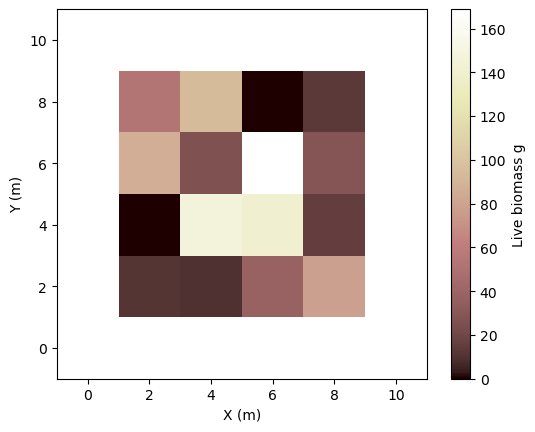

In [11]:
imshow_grid(pg, 'vegetation__total_biomass', at='cell', colorbar_label='Live biomass g')

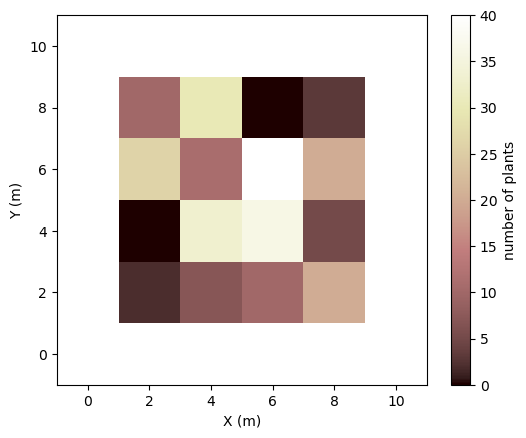

In [12]:
imshow_grid(pg, 'vegetation__n_plants', at='cell', colorbar_label='number of plants')

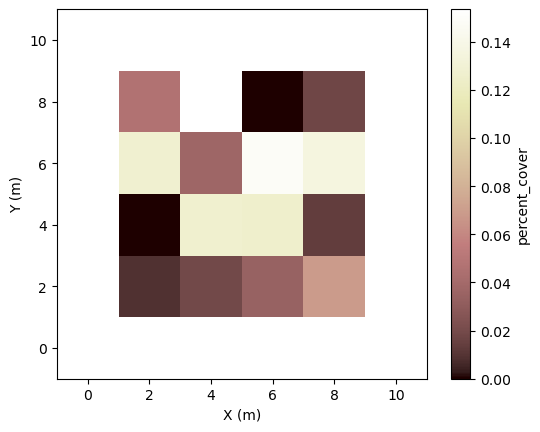

In [13]:
imshow_grid(pg, 'vegetation__percent_cover', at='cell', colorbar_label='percent_cover')

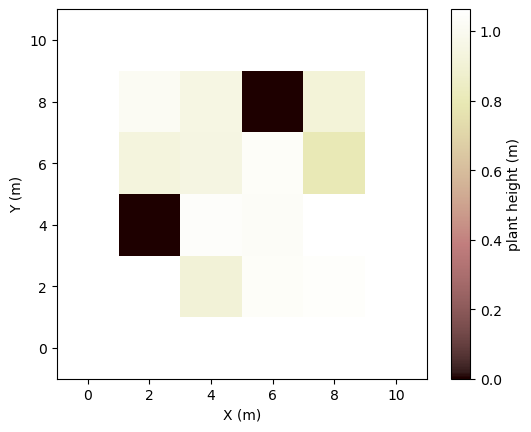

In [14]:
imshow_grid(pg, 'vegetation__plant_height', at='cell', colorbar_label='plant height (m)')

In [15]:
pd.DataFrame(foredune.plant_species[1].species_plants())

,species,pid,cell_index,x_loc,y_loc,root_biomass,leaf_biomass,stem_biomass,storage_biomass,repro_biomass,shoot_sys_width,root_sys_width,shoot_sys_height,root_sys_depth,plant_age,n_stems,pup_x_loc,pup_y_loc,pup_cost,item_id
0,DB,0,0,1.157610,2.402809,3.651877,0.0,0.0,0.902768,1.683897,0.0,0.193660,0.0,0.0,0.0,1,NaN,NaN,NaN,0
1,DB,1,0,2.069377,2.368462,6.905392,0.0,0.0,0.788404,0.625139,0.0,0.254705,0.0,0.0,0.0,1,NaN,NaN,NaN,1
2,DB,2,1,3.258488,2.201009,5.378469,0.0,0.0,0.495825,1.009180,0.0,0.237657,0.0,0.0,0.0,5,NaN,NaN,NaN,2
3,DB,3,1,3.188055,1.067044,1.312589,0.0,0.0,0.551555,0.087708,0.0,0.121840,0.0,0.0,0.0,1,NaN,NaN,NaN,3
4,DB,4,1,3.608654,2.614705,0.807114,0.0,0.0,0.200033,3.010802,0.0,0.100197,0.0,0.0,0.0,3,NaN,NaN,NaN,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,DB,199,13,3.470353,7.460120,1.752362,0.0,0.0,0.575641,2.179555,0.0,0.141820,0.0,0.0,0.0,6,NaN,NaN,NaN,199
200,DB,200,13,3.732273,7.491390,8.739135,0.0,0.0,0.786653,3.486341,0.0,0.287588,0.0,0.0,0.0,4,NaN,NaN,NaN,200
201,DB,201,13,3.823548,8.806364,1.808661,0.0,0.0,0.849671,3.504544,0.0,0.147853,0.0,0.0,0.0,3,NaN,NaN,NaN,201
202,DB,202,15,8.710423,7.819242,2.950649,0.0,0.0,0.734755,3.899650,0.0,0.183938,0.0,0.0,0.0,7,NaN,NaN,NaN,202


## Main model loop script
This is the main model loop that controls the simulation that
- Advances model time 
- Updates environmental variables
- Simulates changes to vegetation communities
- Stores outputs

In [16]:
temp_dir = tempfile.mkdtemp()
os.chdir(temp_dir)
j=-1
for i in range(run_length_d):
    #update temp attribute on grid
    if (i/30).is_integer():
        pg.at_cell['air__temperature_C']= meantemp[j+1]*np.ones(pg.number_of_cells)
        pg.at_cell['radiation__par_tot']= NJ_avg_par[j+1]*np.ones(pg.number_of_cells)
        j+=1
    #update solar radiation on grid
    foredune.run_one_step()
    
    if (i/7).is_integer():
        foredune.save_output()
        write_netcdf("dune.nc",pg, format="NETCDF3_64BIT",append=True, time=(foredune.current_day-foredune.start_date).astype(float)-1, names=['vegetation__total_biomass', 'vegetation__n_plants', 'vegetation__percent_cover'])


I emerge from dormancy
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing seas

In [17]:
output=foredune.get_plant_output()

grid = netcdf_file('crop.nc', 'r')
print(grid.__dict__)

timegrid=grid.variables['t']
timegrid[:]

vegbio=grid.variables['vegetation__total_biomass']
vegbio.shape

vegbio[10,:,:]

In [18]:
output.index.unique(level=2)

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            194, 195, 196, 197, 198, 199, 200, 201, 202, 203],
           dtype='int64', name='item_id', length=204)

In [19]:
output.loc[:, 'BTS',11] #timestep,species,plant number in []

,grid_element,element_id,vegetation__root_biomass,vegetation__leaf_biomass,vegetation__stem_biomass,vegetation__storage_biomass,vegetation__repro_biomass,vegetation__plant_age
time,,,,,,,,
0.0,cell,8.0,1.298662,0.000000,0.000000,0.923784,0.686860,0.0
1.0,cell,8.0,1.298662,0.000000,0.000000,0.923784,0.686860,NaN
8.0,cell,8.0,1.285145,0.000000,0.000000,0.914168,0.679711,NaN
15.0,cell,8.0,1.271767,0.000000,0.000000,0.904653,0.672635,NaN
22.0,cell,8.0,1.258530,0.000000,0.000000,0.895236,0.665634,NaN
29.0,cell,8.0,1.245429,0.000000,0.000000,0.885917,0.658705,NaN
36.0,cell,8.0,1.231614,0.000000,0.000000,0.876090,0.651399,NaN
43.0,cell,8.0,1.217812,0.000000,0.000000,0.866272,0.644099,NaN
50.0,cell,8.0,1.204165,0.000000,0.000000,0.856564,0.636880,NaN


output.loc[21.0]

In [20]:
pd.set_option('display.max_rows',None)
pd.DataFrame(foredune.plant_species[1].species_plants())

,species,pid,cell_index,x_loc,y_loc,root_biomass,leaf_biomass,stem_biomass,storage_biomass,repro_biomass,shoot_sys_width,root_sys_width,shoot_sys_height,root_sys_depth,plant_age,n_stems,pup_x_loc,pup_y_loc,pup_cost,item_id
0,DB,0,0,1.157610,2.402809,2.558930,2.534838,2.411924,6.532908e-06,0.000025,0.101155,0.151732,1.273503,0.0,0.0,1,NaN,NaN,NaN,0
1,DB,1,0,2.069377,2.368462,2.622227,2.596836,2.473348,6.731927e-06,0.480533,0.102742,0.154113,1.260991,0.0,0.0,1,NaN,NaN,NaN,1
2,DB,5,2,5.856923,2.343194,2.598277,2.572425,2.452501,4.261322e-06,0.097831,0.102163,0.153244,1.265506,0.0,0.0,2,NaN,NaN,NaN,5
3,DB,7,2,6.057232,2.304594,2.558894,2.535796,2.409408,1.876001e-06,0.193943,0.101135,0.151702,1.273665,0.0,0.0,5,NaN,NaN,NaN,7
4,DB,11,2,6.461536,2.375332,2.586794,2.562670,2.437615,5.956851e-06,0.312796,0.101846,0.152769,1.267999,0.0,0.0,6,NaN,NaN,NaN,11
5,DB,12,2,5.644140,2.190558,2.606512,2.580552,2.460339,7.465601e-06,0.171394,0.102368,0.153551,1.263904,0.0,0.0,4,NaN,NaN,NaN,12
6,DB,15,3,7.301644,1.227059,2.602399,2.578545,2.451280,1.394339e-07,0.562950,0.102226,0.153338,1.265013,0.0,0.0,6,NaN,NaN,NaN,15
7,DB,17,3,8.480901,1.341641,2.574952,2.550532,2.427466,5.040792e-06,0.115726,0.101559,0.152338,1.270276,0.0,0.0,6,NaN,NaN,NaN,17
8,DB,18,3,8.770264,2.506835,2.602750,2.576439,2.457764,2.054124e-06,0.058948,0.102282,0.153423,1.264573,0.0,0.0,6,NaN,NaN,NaN,18
9,DB,20,3,7.854555,2.840572,2.595731,2.570104,2.449596,3.943658e-06,0.113173,0.102096,0.153144,1.266032,0.0,0.0,3,NaN,NaN,NaN,20


In [21]:
biomass = output["vegetation__root_biomass"].values
display(biomass)


array([ 0.97739607,  0.06222222,  0.70662443, ...,  2.55542571,
        2.57176347,  2.60333242])

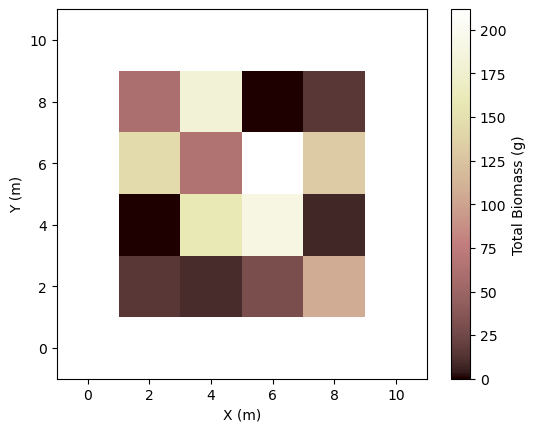

In [22]:
imshow_grid(pg, 'vegetation__total_biomass', at='cell', colorbar_label='Total Biomass (g)')

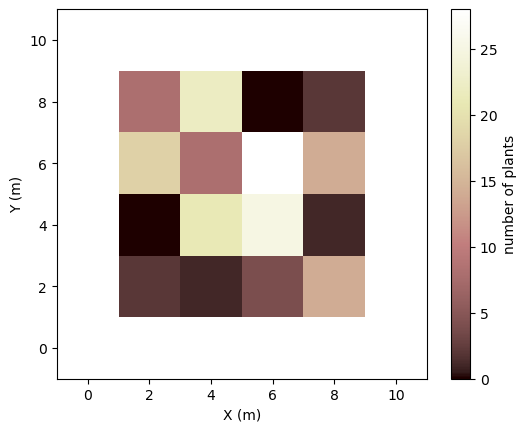

In [23]:
imshow_grid(pg, 'vegetation__n_plants', at='cell', colorbar_label='number of plants')

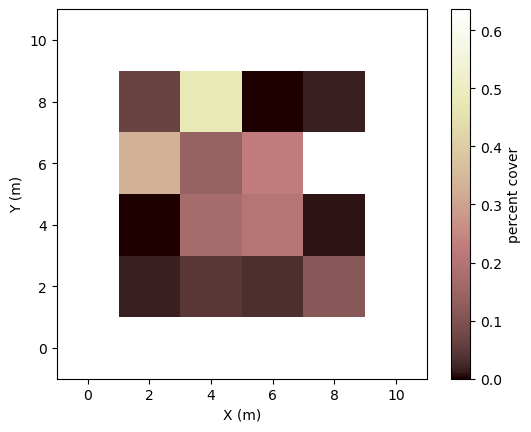

In [24]:
imshow_grid(pg, 'vegetation__percent_cover', at='cell', colorbar_label='percent cover')

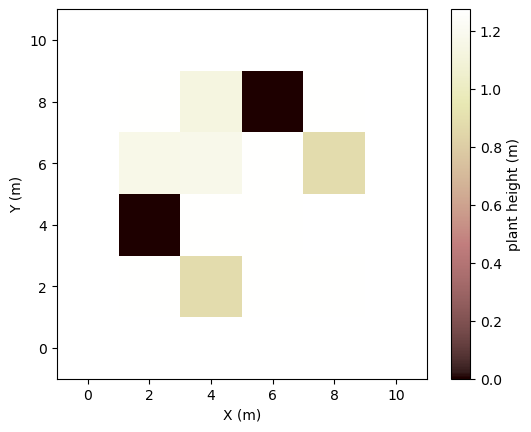

In [25]:
imshow_grid(pg, 'vegetation__plant_height', at='cell', colorbar_label='plant height (m)')

grid.close()